In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
# Pull Data 
ada_data = yf.download('ADA-USD', start='2017-01-01', end='2022-01-01')
ada_df = pd.DataFrame(ada_data)

[*********************100%***********************]  1 of 1 completed


In [4]:
ada_df = ada_df.drop(columns=['Adj Close','Volume', 'Open', 'High', 'Low'])

In [5]:
ada_df.head()

,Close
Date,
2017-11-09,0.032053
2017-11-10,0.027119
2017-11-11,0.027437
2017-11-12,0.023977
2017-11-13,0.025808


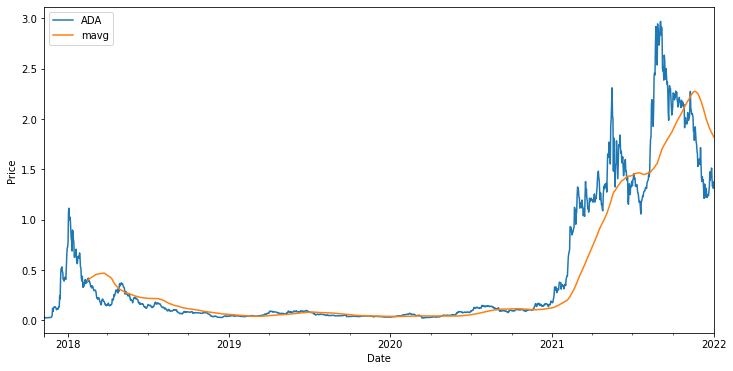

In [6]:
# Rolling mean
close_px = ada_df['Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='ADA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [7]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = ada_df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Close
1510,18989.0,1.402264
1511,18990.0,1.330814
1512,18991.0,1.360415
1513,18992.0,1.310209
1514,18993.0,1.376975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


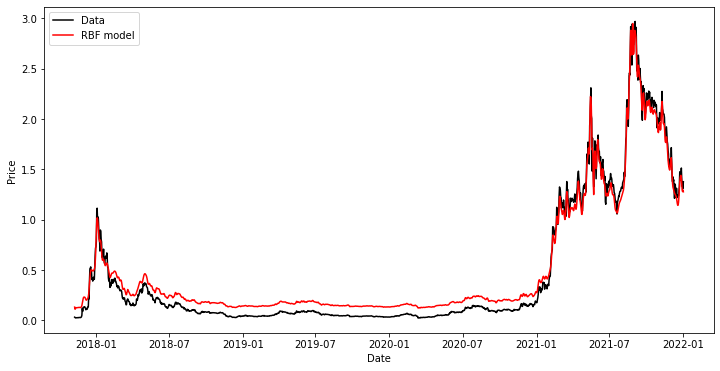

In [8]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates = dates_df['Date'].to_numpy() 
prices = ada_df['Close'].to_numpy()

#Convert to 1d Vector
dates = dates.reshape(-1, 1)
prices = prices.reshape(-1, 1)

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Create train set of adj close prices data:
train_data = ada_df.loc[:,'Close'].to_numpy()
print(train_data.shape) # 1258 

(1515,)


In [10]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [11]:
#'''Function to create a dataset to feed into an LSTM'''
#def create_dataset(dataset, look_back):
    #dataX, dataY = [], []
    #for i in range(len(dataset)-look_back):
       # a = dataset[i:(i + look_back), 0]
       # dataX.append(a)
       # dataY.append(dataset[i + look_back, 0])
   # return np.array(dataX), np.array(dataY)

In [12]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [31]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(ada_df, window_size, feature_column, target_column)

In [32]:
 # Use 70% of the data for training and the remaineder for testing
split = int(.7 * len(X))
X_train = X[:split - 1]
X_test = X[split:]
y_train = y[:split - 1]
y_test = y[split:]

In [33]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_scaler.fit(X_train)
y_scaler.fit(y_train)

# Scale the training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Scale the y_test data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

In [34]:
 # Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

In [35]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
74/74 [==============================] - 4s 16ms/step - loss: 0.0067 - val_loss: 0.0010
Epoch 2/20
74/74 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 2.1533e-04
Epoch 3/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0026 - val_loss: 1.0616e-04
Epoch 4/20
74/74 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 4.6627e-05
Epoch 5/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 3.0836e-05
Epoch 6/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 1.6724e-04
Epoch 7/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 7.0883e-05
Epoch 8/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 2.6352e-04
Epoch 9/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 7.1706e-05
Epoch 10/20
74/74 [==============================] - 1s 8ms/step - loss: 0.0016 - val

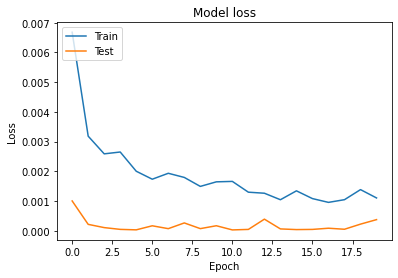

In [36]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# Get the stock prices for 2019 to have our model make the predictions
#test_data = ada_df['Close'].values
#test_data = test_data.reshape(-1,1)
#test_data = scaler.transform(test_data)

# Create the data to test our model on:
#time_steps = 36
#X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
#y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
#X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

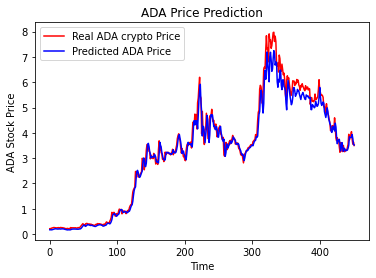

In [38]:
plt.plot(org_y, color = 'red', label = 'Real ADA crypto Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted ADA Price')
plt.title('ADA Price Prediction')
plt.xlabel('Time')
plt.ylabel('ADA Stock Price')
plt.legend()
plt.show()